In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import dump

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

MAPE = 0.0482513082531504
MAE = 2183.651213466314
MSE = 6449115.68745678
0.9110146648618164


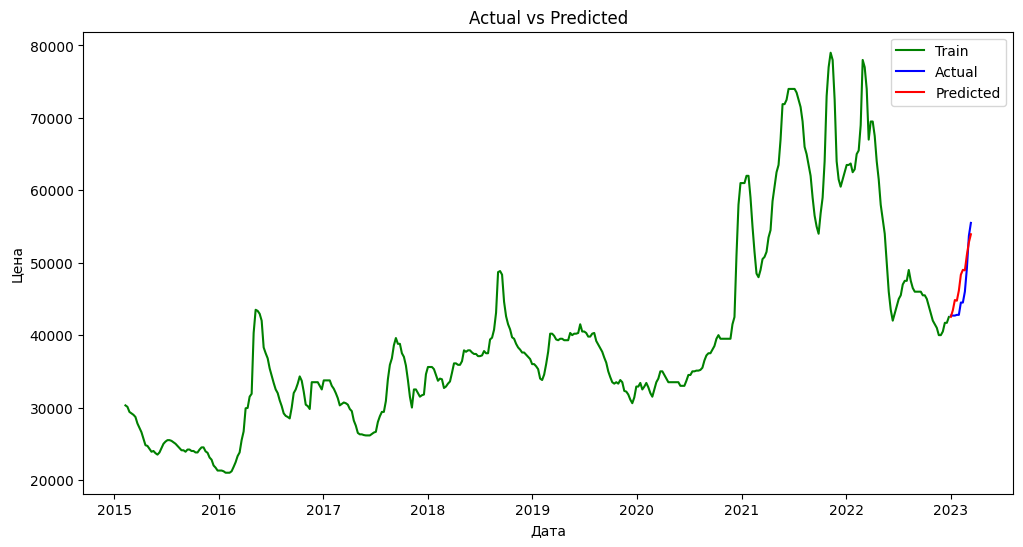

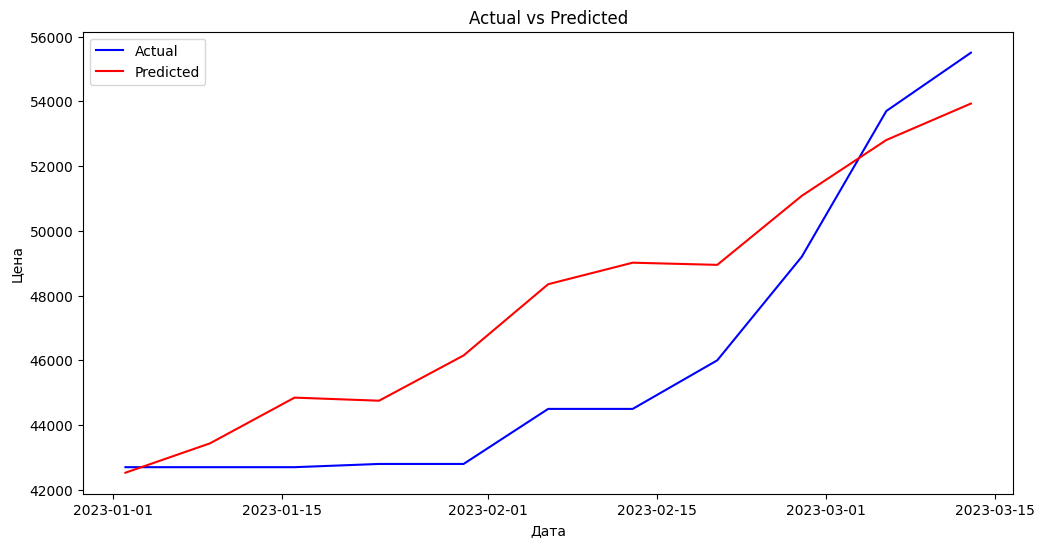

In [ ]:
data = pd.read_csv('data/full.csv')

data.dt = pd.to_datetime(data.dt) # Приводим дату в тип pandas
data = data.set_index('dt') # Делаем колонку даты индексом, даем ей периодичность месяц ('MS' - month start)

lag_days = 0  # Количество лагов
for lag in range(1, lag_days + 1):
    data[f'lag_{lag}'] = data['pfr'].shift(lag)

t = list(data.columns)
t.remove('pfr')


train = data.head(-11)
test = data.tail(11)

X_train = train[t]
y_train = train['pfr']

X_test = test[t]
y_test = test['pfr']

###############################################################################################

model = CatBoostRegressor(iterations=5000, learning_rate=0.01, depth=6, verbose=0)
model.fit(X_train, y_train)

dump(model, 'catBoostModel.joblib', compress=9)

y_pred = model.predict(X_test)

###############################################################################################

# Оценка модели
print(f"MAPE = {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")

correlation = np.corrcoef(y_test, y_pred)[0, 1]
print(correlation)

###############################################################################################

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train', color='green')
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

###############################################################################################

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from catboost import CatBoostRegressor

# # Определение модели
# model = CatBoostRegressor()

# # Определение параметров для поиска
# param_grid = {
#     'iterations': [500, 1000, 5000],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'depth': [4, 6, 8]
# }

# # Сеточный поиск
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
# grid_search.fit(X_train, y_train)

# # Лучшие параметры

# print("Лучшие параметры:", grid_search.best_params_)

In [27]:
good = {
    'MAPE':{'qua':0, 'res':float('inf')},
    'MAE':{'qua':0, 'res':float('inf')},
    'MSE':{'qua':0, 'res':float('inf')},
    'correlation':{'qua':0, 'res':float('-inf')}
}

for i in range(400):

    data = pd.read_csv('data/full.csv')

    data.dt = pd.to_datetime(data.dt) # Приводим дату в тип pandas
    data = data.set_index('dt') # Делаем колонку даты индексом, даем ей периодичность месяц ('MS' - month start)

    lag_days = i  # Количество лагов
    for lag in range(1, lag_days + 1):
        data[f'lag_{lag}'] = data['pfr'].shift(lag)

    t = list(data.columns)
    t.remove('pfr')


    train = data.head(-11)
    test = data.tail(11)

    X_train = train[t]
    y_train = train['pfr']

    X_test = test[t]
    y_test = test['pfr']

    ###############################################################################################

    # model = CatBoostRegressor(iterations=grid_search.best_params_['iterations'], learning_rate=grid_search.best_params_['learning_rate'], depth=grid_search.best_params_['depth'], verbose=0)
    model = CatBoostRegressor(iterations=5000, learning_rate=0.01, depth=6, verbose=0)
    model.fit(X_train, y_train)
    plt.show()

    y_pred = model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    correlation = np.corrcoef(y_test, y_pred)[0, 1]

    asist = 1 - abs(correlation)

    if good['MAPE']['res'] > mape:
        good['MAPE']['qua'] = i
        good['MAPE']['res'] = mape

    if good['MAE']['res'] > mae:
        good['MAE']['qua'] = i
        good['MAE']['res'] = mae

    if good['MSE']['res'] > mse:
        good['MSE']['qua'] = i
        good['MSE']['res'] = mse

    if good['correlation']['res'] < asist:
        good['correlation']['qua'] = i
        good['correlation']['res'] = correlation

    print('Коэффициент корреляции:', correlation)

    print('-----------------------')
    print(i)
    print(good)
    print('-----------------------')


Коэффициент корреляции: 0.9110146648618164
-----------------------
0
{'MAPE': {'qua': 0, 'res': 0.0482513082531504}, 'MAE': {'qua': 0, 'res': 2183.651213466314}, 'MSE': {'qua': 0, 'res': 6449115.68745678}, 'correlation': {'qua': 0, 'res': 0.9110146648618164}}
-----------------------
Коэффициент корреляции: 0.8714705408560385
-----------------------
1
{'MAPE': {'qua': 0, 'res': 0.0482513082531504}, 'MAE': {'qua': 0, 'res': 2183.651213466314}, 'MSE': {'qua': 0, 'res': 6449115.68745678}, 'correlation': {'qua': 0, 'res': 0.9110146648618164}}
-----------------------
Коэффициент корреляции: 0.8554781689927177
-----------------------
2
{'MAPE': {'qua': 0, 'res': 0.0482513082531504}, 'MAE': {'qua': 0, 'res': 2183.651213466314}, 'MSE': {'qua': 0, 'res': 6449115.68745678}, 'correlation': {'qua': 0, 'res': 0.9110146648618164}}
-----------------------
Коэффициент корреляции: 0.8910580916206785
-----------------------
3
{'MAPE': {'qua': 0, 'res': 0.0482513082531504}, 'MAE': {'qua': 0, 'res': 2183.6

KeyboardInterrupt: 

In [ ]:
print(good)
# print("Лучшие параметры:", grid_search.best_params_)

{'MAPE': {'qua': 0, 'res': 0.03717299116090404}, 'MAE': {'qua': 0, 'res': 1855.6340807478439}, 'MSE': {'qua': 0, 'res': 6612524.0336970305}}
Лучшие параметры: {'depth': 4, 'iterations': 500, 'learning_rate': 0.2, 'verbose': 0}
